# Titanic

### TODO add a read me

### 1. Preparing the data

First import necessary modules

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

Please modify these paths before running your code. <br> In defeault the csv files should be in under Data folder

In [2]:
train_path = "Data" + os.sep + "train.csv"
test_input_path = "Data" + os.sep + "test.csv"
test_output_path = "Data" + os.sep + "gender_submission.csv"

Reading train and test files

In [3]:
train_dataset = pd.read_csv(train_path)
test_input_dataset = pd.read_csv(test_input_path)
test_output_path = pd.read_csv(test_output_path)

Let's understand the data

In [4]:
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Before countinue lets seperate our survived from training set

In [5]:
train_target = train_dataset[["Survived"]]
train_dataset.drop("Survived", axis=1, inplace=True)

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


First i want to deal with null inputs lets see if there is any

In [7]:
train_dataset.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Wow ok.. There is 889 input data and Cabin has 687 null data i think it is best to discard this feature

In [8]:
train_dataset.drop("Cabin", axis=1,inplace=True)   # axis=1 because in default this method drops rows not columns
unnecessary_features = ["Cabin"]

In [9]:
def drop_features(dataframe, features):
    dataframe.drop(features, axis=1, inplace=True, errors="ignore")

Ok now lets focus on Age feature lets examine this feature

<Axes: ylabel='Frequency'>

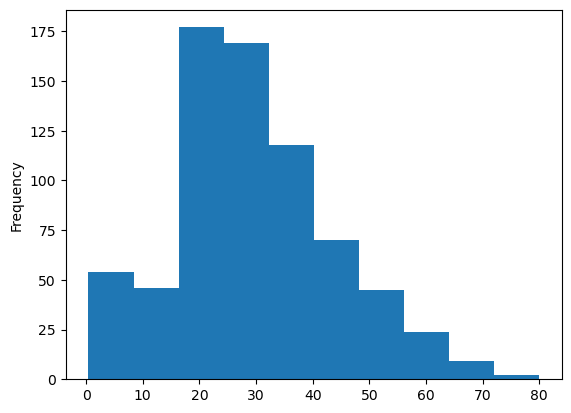

In [10]:
train_dataset["Age"].plot(kind="hist")

I think it is best to fill with mean value

In [11]:
all_imputers = []  # I am going to use this variable later on for making things more easier when we encounter unproper dataset
imputed_features = []
imputer_age = SimpleImputer(strategy='mean')
train_dataset["Age"] = imputer_age.fit_transform(train_dataset[["Age"]])
all_imputers.append(imputer_age)
imputed_features.append("Age")

Lastly we need to check our Embarked fature lets examine that columns

In [12]:
train_dataset["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

I am going to fill na values with most seen one S 

In [13]:
imputer_embarked = SimpleImputer(strategy='most_frequent')
train_dataset["Embarked"] = imputer_embarked.fit_transform(train_dataset[["Embarked"]])
all_imputers.append(imputer_embarked)
imputed_features.append("Embarked")

Ok now lets see what is our columns data types

In [14]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


First lets look at Sex object

In [15]:
train_dataset["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Ok interesting we only got two. lets one hot encode it

Now lets look at Embarked feature again for encoding it

In [16]:
train_dataset["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

Lets write a encoder function so we can call this function again and again for traning and testing

In [17]:
all_encoders = [OneHotEncoder(handle_unknown="error")]  # It looks like we will have only one ecoder but lets do it like that for readability and maintainability
encoded_features = ["Sex","Embarked"]
all_encoders[0].fit(train_dataset[["Sex","Embarked"]])
# Notice that we did not apply transform because
# One hot encoding requires few steps therefore we
# will write a function for that

OneHotEncoder()

In [18]:
def encode(dataframe, encoder, features):
    encoded_array = encoder.transform(dataframe[features]).toarray().astype('int32')  
    # It returns float64 i want int32
    # We already fit the encoder for our training data we only need to transform
    dataframe.drop(features, axis=1, inplace=True)
    encoded_dataframe = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out())
    return pd.concat([dataframe, encoded_dataframe], axis=1)

In [19]:
for encoder in all_encoders:
    train_dataset = encode(train_dataset, encoder, encoded_features)  # Yes, i know it only has one but it is nice practice i think

Let's check it

In [20]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Ticket       891 non-null    object 
 7   Fare         891 non-null    float64
 8   Sex_female   891 non-null    int32  
 9   Sex_male     891 non-null    int32  
 10  Embarked_C   891 non-null    int32  
 11  Embarked_Q   891 non-null    int32  
 12  Embarked_S   891 non-null    int32  
dtypes: float64(2), int32(5), int64(4), object(2)
memory usage: 73.2+ KB


In [21]:
train_dataset[["Name","Ticket"]]

,Name,Ticket
0,"Braund, Mr. Owen Harris",A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599
2,"Heikkinen, Miss. Laina",STON/O2. 3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803
4,"Allen, Mr. William Henry",373450
...,...,...
886,"Montvila, Rev. Juozas",211536
887,"Graham, Miss. Margaret Edith",112053
888,"Johnston, Miss. Catherine Helen ""Carrie""",W./C. 6607
889,"Behr, Mr. Karl Howell",111369


In [22]:
train_dataset["Name"].value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

In [23]:
train_dataset["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

I can not think any transformation for ticket and name and for now i am going to drop them

In [24]:
unnecessary_features.append("Name")
unnecessary_features.append("Ticket")
drop_features(train_dataset, unnecessary_features)

In [25]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   Sex_female   891 non-null    int32  
 7   Sex_male     891 non-null    int32  
 8   Embarked_C   891 non-null    int32  
 9   Embarked_Q   891 non-null    int32  
 10  Embarked_S   891 non-null    int32  
dtypes: float64(2), int32(5), int64(4)
memory usage: 59.3 KB


## Feature Scaling

Now everythink is numerical what we need to do feature scaling but beacuse of not every ML model required feature scaling we will take copy and move on 

In [26]:
train_dataset_scaled = train_dataset.copy()

Let's see our features histogram bars we do not need to scale encoded features so i am going to draw histogram just for the rest

In [38]:
ft = {feature  for feature in encoder.get_feature_names_out() for encoder in all_encoder}  # TODO BURADA KALDIK


NameError: name 'all_encoder' is not defined

In [27]:

columns_to_scale = list(set(train_dataset_scaled.columns) - set(encoder.get_feature_names_out() for encoder in all_encoders))
train_dataset_scaled[columns_to_scale].hist(figsize=(10, 10))

TypeError: unhashable type: 'numpy.ndarray'

Lets do minmax scaling for PassengerId beacuse it is nicesquare shaped every Id has a equal probability

I want this range for -1 to 1

array([[<Axes: title={'center': 'PassengerId'}>]], dtype=object)

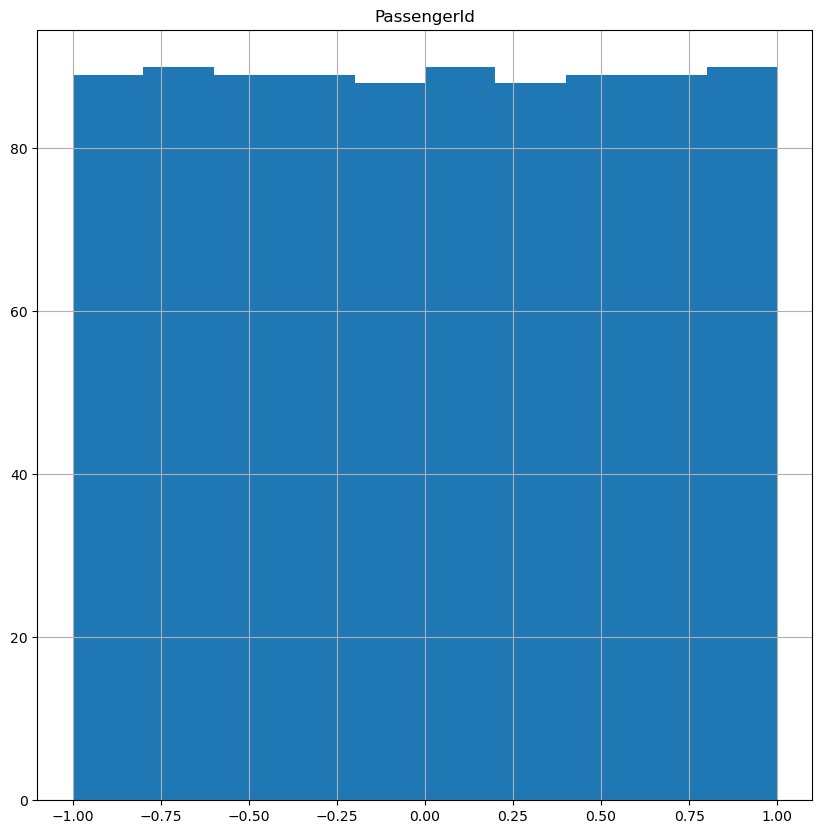

In [26]:
minmaxscaler_passengerid = MinMaxScaler(feature_range=(-1, 1))
train_dataset_scaled[["PassengerId"]] = minmaxscaler_passengerid.fit_transform(train_dataset_scaled[["PassengerId"]])
train_dataset_scaled[["PassengerId"]].hist(figsize=(10, 10))

For age lets do standart normalization

array([[<Axes: title={'center': 'Age'}>]], dtype=object)

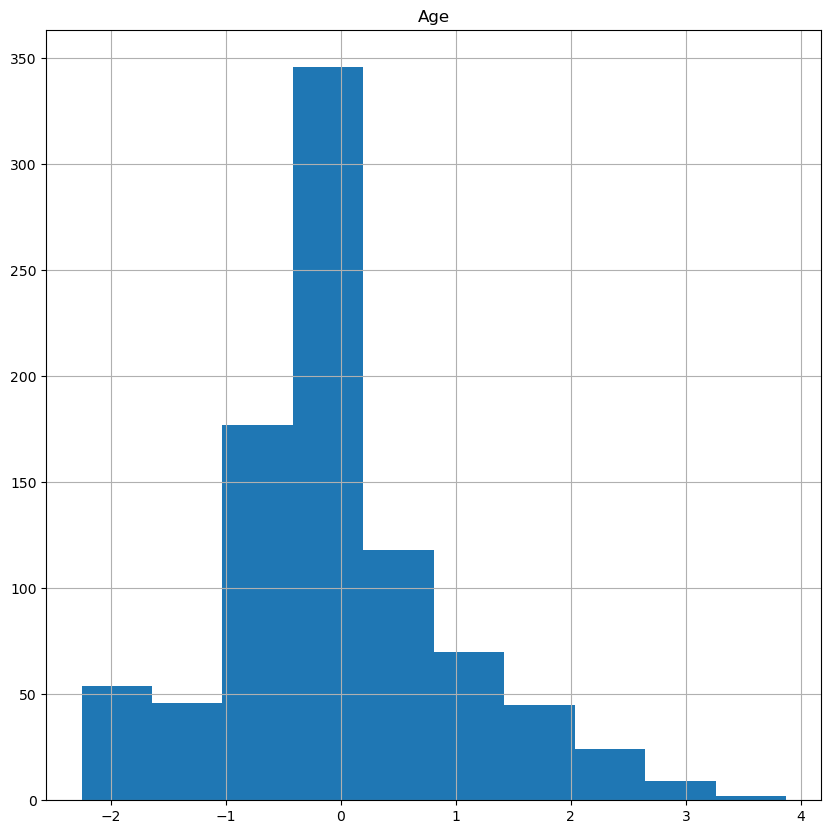

In [27]:
standardscaler_age = StandardScaler()
train_dataset_scaled[["Age"]] = standardscaler_age.fit_transform(train_dataset_scaled[["Age"]])
train_dataset_scaled[["Age"]].hist(figsize=(10, 10))

Let's do scaling for our test data

In [28]:
test_input_dataset.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Lets fill the null values